# Mezclado de regiones usando la ecuación de Poisson 

Trabajo final de visión por computador curso 2021-2022

Miembros equipo: 
- Exequiel Alberto Castro Rivero 
- Blanca Cano Camarero 

## Descripción del problema   
TODO: issue #8 redacción mejor cuando esté acabado 
Clonación de regiones   

## Elementos del problema   

Relacionaremos la notación usada de manera teórica: 
- **Imagen fuente**: Denotada en teoría como $S$ será referenciada como la variable `InputSource`. 
- **Imagen destino**: Simbolizada como $\Omega$ aquí será denotada como `OutputSource`.
  
Todo pixel $p$ de $S$ será un par que denotará sus coordenada dentro de la imagen. 
Y su **conjunto de vecinos del pixel $p$** denotado como $N_p$ serán calculados gracias a la función `Neighborhood` que definida en la celda de `Código: 1`. 


Será necesario calcular también el **borde  de $\Omega$**, que definíamos de manera formal como: 

$$\partial\Omega = \{ p \in S \setminus \Omega : N_p \cap \Omega \neq  \emptyset \}$$

Su cálculo se realizará mediante la función `SourceBoundary`, también definida en la celda `Código: 1`.



In [2]:
# Código: 0   Import básico y otras definiciones globales auxiliares
import numpy as np
from itertools import chain # Herramienta de programación funcional

# Para la lectura de las imágenes
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
#import scipy.special

# TODO: BORRAR la función TODO ANTES DE ENTREGAR
def TODO (ms): 
    '''
    Función auxiliar para indicar que una función está en desarrollo
    '''
    print('TODO', ms)



In [2]:
#Código: 1
def Neighborhood(pixel : list, inputChannel : np.ndarray )->list:
    '''
    pixel: tupla o lista de dos números naturales que indican  las coordenadas del pixel. se comprobará que que es coherente con las dimensiones de la imagen
    inputChannel: imagen a la que pertenece el pixel p. Debe ser solo un canal. Es decir, será una matriz de dos dimensiones. 
    '''
    x,y = pixel
    #Dimensiones de inputChannel coherente con el pixel demandado
    x_max , y_max = np.shape(inputChannel) 
    DimensionChecker = lambda x,y: 0 <= x < x_max and 0 <= y < y_max
    assert DimensionChecker(x,y), f' El pixel {pixel} se sale de las dimensiones {x_max}{y_max}'

    #Se devuelven vecino válidos
    neighborhoodCoordinates = filter(
        lambda tuple : DimensionChecker(tuple[0], tuple[1]),
        list( chain.from_iterable(([x+i,y], [x, y+i]) for i in [-1,1])) 
    )
   
    return list(neighborhoodCoordinates)


def SourceBoundary(inputChannel: np.ndarray, O: set )-> set : 
    '''
    Se pretenda calcular el borde de imagen destino. 

    inputChannel: imagen a la que pertenece el pixel p. Debe ser solo un canal. Es decir, será una matriz de dos dimensiones. 
    O: Supondremos que O son n conjunto de pares de tuplas de coordenadas. 

    Devuelve un conjunto de coordenadas en tuplas que son el borde de O.
    ''' 
    # calculamos el conjunto de puntos S
    x_len, y_len = np.shape(inputChannel)
    S = set( (i,j) for i in range(x_len) for j in range(y_len)) 
    # Calculamos la diferencia 
    difference = S.difference(O)
    # Filtramos los puntos que cumplen la condición de que sus vecinos están en O
    boundary = set(filter(
        lambda p : len(set(
            map(
                lambda l : tuple(l),
                Neighborhood(p, inputChannel)
            )
            ).intersection(O))>0,
        difference
    ))

    return boundary

### Complejidad de las funciones implementadas 

Para la función `Neighborhood(pixel : list, inputChannel : np.ndarray )`  de la celda `Código: 1` su eficiencia reside: 
- Coste funciones ya implementada de python y bibliotecas. 
- De nuestro propio código.   

La de nuestro propio código es $O(1)$ ya que no existe ningún bucle interno que dependenda de la entrada de la función. 
Para funciones externas la única función que podría contener un coste mayor de $O(1)$ podría ser la función `shape` de numpy. Consultando su implementación [1] se puede apreciar que usa dos funciones `len` que volviendo a analizar su eficiencia [2] esta es $O(1)$. 

Por lo que concluimos que `Neigborhood` tiene una complejidad de $O(1)$. 

TODO Complejidad de `SourceBoundary`. 

## Copiado prístino   

Para una implementación numérica, la traducción de las especificaciones continuas se trasladan directamente en : 

$\langle p,q \rangle, v_{p,q} = g_p - g_q$

Donde $g_p$ representa el valor del pixel $p$ en la imagen de entrada. 
Así pues el resultado de la implementación queda escrito en la celda `Código: 2` la siguiente. 

In [ ]:
# Código: 2 Implementación del campo de guía  

def GuidanceFieldGenerator(inputChannel : np.ndarray):
    ''' Devuelve la función v_{p,q} = g_p - g_q$
    Para el caso particular en que g es inputChannel
    '''
    return lambda p,q : inputChannel[p[0]][p[1]] - inputChannel[q[0]][q[1]]

### Lectura de imágenes  

No olvidemos ahora la lectura de las imágenes. 

TODO: Aquí queda pensar cómo se va a leer para definir correctamente cada uno de los dominios. 

También será necesario buscar imágenes que sean adecuadas para nuestro problema, hemos realizado capturas del artículo original [3]. 

Para leer las imágenes utilizaremos las funciones de `opencv`, las leeremos en color. Como resultado (ver referencia a (1) en la salida de códico: 3)
obtendremos dos canales con los que trabajaremos de forma separada. 

Además podemos observar en la salida (1) que el número de píxeles de la imagen *Piel rugosa* es de $968 \times 1052$, mientras que para *Pintada de pared* es de $1092 \times 2138$.


(Nota para el futuro: estas imágenes puede ser muy grandes)


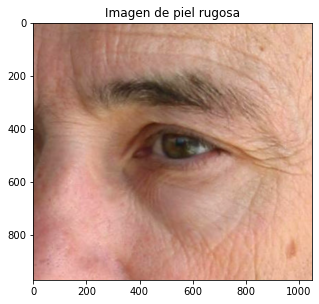

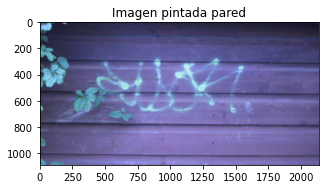

Salida (1) Sobre el tamaño de las imágenes: 
 Shape piel rugosa: (968, 1052, 3)
Shape pintada pared: (1092, 2138, 3)


In [10]:
# Código: 3 Funciones lectura de imágenes 
'''
Salvo tener la necesidad de cambiar la ruta donde se leen las imágenes, no es necesario la lectura de ésta
celda, ya que contiene: 
1. Bibliotecas necesarias.
2. Indicación de la ruta de donde se toman las imágenes y la lectura de las imágenes.
3. Conjunto de funciones auxiliaras como las utilizadas para mostrar imágenes en pantalla. 
Éstas están tomadas de la práctica 0 y a lo sumo tienen ligeras modificaciones.  
'''
# ___ Lectura de imágenes___
# path carpeta con imágenes
path = 'images/'

# Devuelve si una imagen está en blanco o negro 
def IsGreyScale(img):
    '''Devuelve si una imagen está en blanco y negro'''
    return len(img.shape) == 2

# Reutilizamos código de la práctica inicial
def ReadImage(filename, flagColor):
  '''
  @param filename: nombre de la foto 
  @para flagColor: boolean escala de grises o color
  '''
  return np.asarray(cv.imread(filename, flagColor), dtype=float)
## Flags
flagColor = cv.IMREAD_ANYCOLOR
flagGrey = cv.IMREAD_GRAYSCALE


## Algunas funciones para pintar imágenes 
# Para pintar imágenes
def Normalize (img):
    ''' Transforma una imagen de números reales
    al intervalo [0,1] 
    '''
    min = np.min(img)
    max = np.max(img)

    normalized_img = np.copy(img)

    if max - min > 0:
        normalized_img = (normalized_img - min) / (max - min)
    else: 
        normalized_img *= 0 # suponemos todo blanca
    return normalized_img

def PrintOneImage( img, title=None, normalize= True, size = (13,13)):
    '''Muestra una imagen usando imshow'''

    plt.figure(figsize=size)
    if normalize:
        img = Normalize(img)
    if IsGreyScale(img):
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img[:,:,::-1])
    if title:
        plt.title(title)
    plt.show()


## Leemos algunas imágenes y las mostramos  
pathPielRugosa = path + 'PielRugosa.png'
pathPintadaPared = path + 'PintadaEnPared.png'
imgPielRugosa = ReadImage(pathPielRugosa, flagColor) 
imgPintadaPared = ReadImage(pathPintadaPared, flagColor)
PrintOneImage(imgPielRugosa, title='Imagen de piel rugosa',size=(5,5))
PrintOneImage(imgPintadaPared, title='Imagen pintada pared', size=(5,5))

# Características de las imágenes 
print('Salida (1) Sobre el tamaño de las imágenes: ')
print(f' Shape piel rugosa: {imgPielRugosa.shape}')
print(f'Shape pintada pared: {imgPintadaPared.shape}')


### Selección de regiones   

Es necesario definir un sistema de selección de regiones para nuestro problema, es decir de lo que de manera teórica sería definir las regiones $\Omega$ y $S$. Para ello hemos definido el siguiente método: 

Se subirán dos imágenes, una la original sin seleccionar el área, otra la que tiene el área seleccionada. Para indicar las regiones lo que se hará será cambiar cambiar el color de esa región. 

Mostramos un ejemplo a continuación en `Código: 5`. 

La implementación del cálculo, en sección `Código: 4` de región consiste en cambiar el color de las regiones que se quieren cambiar:
Se restan las matrices que representan las imágenes originales y la nueva, las entradas no nulas representa los píxeles seleccionados.
Este método supone un esfuerzo al que edita las imágenes: debe cambiar el color correctamente (es decir si lo hace coloreando esa región con un color, debe asegurarse de que ese color no está en ningún pixel de la zona. Para ello recomendamos usar algoritmos propios del sistema de edición con que edite la foto.)

Otro problema ahora a hacer frente es dónde posicionar esos píxeles en la otra imagen y con qué escala.
Eso se hará gracias a un homomorfismo. (TODO: issue #12 Revisar que la función utilizada es pegado regiones es homomorfismo).




In [26]:
# Código 4: Selección de regiones 

def SelectedRegion( originalImage: np.ndarray, selectedImage : np.ndarray, showImage = False) -> set :
    '''
    Devuelve un conjunto de pares de coordenadas que han sido modificadas en alguno de los tres canales. 
    Su correspondencia teórica sería $\Omega$. 
    originalImage: Imagen en la que no se ha seleccionado ningún área. 
    selectedImage: Imagen con el área seleccionada. 
    showImage: Booleano si True muestra las regiones selecionadas. 
    '''
    differenceMatrix = originalImage - selectedImage
    if(showImage):
        PrintOneImage(differenceMatrix, title= 'Regiones seleccionadas',size=(7,7))
    #seleccionamos las coordenadas que han cambiado
    x_len, y_len, _ = differenceMatrix.shape
    selectedRegion = set()
    valorAntiguo = None
    for x in range(x_len):
        for y in range(y_len): 
            if differenceMatrix[x][y].all != valorAntiguo:
                print(differenceMatrix)
                valorAntiguo = differenceMatrix[x][y]
                selectedRegion.add((x,y))
    return selectedRegion


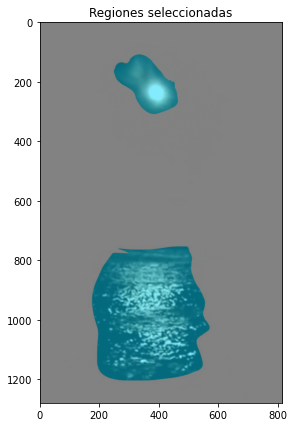

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [27]:
SelectedRegion(imgLunaYReflejo, imgLunaSeleccionada, True) 

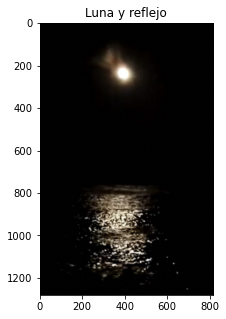

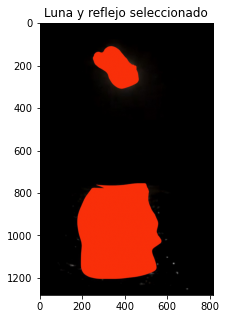

In [14]:
# Código 5: Ejemplo de selección de imágenes

#Leemos las imágenes y las mostramos 
pathLunaYReflejo = path + 'LunaYReflejo.jpg'
pathLunaSeleccionada = path + 'LunaSeleccionadaAmbasRegiones.jpg'
imgLunaYReflejo = ReadImage(pathLunaYReflejo, flagColor) 
imgLunaSeleccionada = ReadImage(pathLunaSeleccionada, flagColor)
PrintOneImage(imgLunaYReflejo, title='Luna y reflejo',size=(5,5))
PrintOneImage(imgLunaSeleccionada, title='Luna y reflejo seleccionado', size=(5,5))


# Bibliografía y otros recursos  

[1] Web. Título: Implementación de funciones de la función `shape`. URL: https://github.com/pandas-dev/pandas/blob/master/pandas/core/frame.py Fecha última consulta: 01-01-22. Línea de código: 822-842.

[2] Web. Título: *Internal working of the Len() function in Python. URL: https://www.geeksforgeeks.org/internal-working-of-the-len-function-in-python/ autor: GeeksforGeeks. Fecha última consulta: 01-01-22. 

[3] Artículo *Poisson Image Editing* Patrick Pérez, Michel Gangnet, and Andrew Blake. 2003. Poisson image editing. ACM Trans. Graph. 22, 3 (July 2003), 313–318. DOI:https://doi.org/10.1145/882262.882269